In [1]:
# Importation des librairies nécessaires à la prédiction de revenus
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from datetime import datetime
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# Importation des librairies qui vont nous permettre de calculer le R² de nos variables
from scipy import stats
import scipy.stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.api as sms

plt.style.use('ggplot')

In [2]:
# Chargement de nos dataframe
train = pd.read_csv('train_stat.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

In [3]:
# Analyse de la variance de la variable explicative 'country' sur la variable qu'on cherche à expliquer 'income'
alpha = 0.05
anova_income_4 = smf.ols('revenue ~ budget + popularity + release_year + runtime', data = train).fit(alpha=alpha)
anova_income_4.summary().tables[0]

Dep. Variable:,revenue,R-squared:,0.413
Model:,OLS,Adj. R-squared:,0.412
Method:,Least Squares,F-statistic:,526.9
Date:,"Wed, 23 Mar 2022",Prob (F-statistic):,0.00
Time:,11:55:54,Log-Likelihood:,-6777.8
No. Observations:,3000,AIC:,1.357e+04
Df Residuals:,2995,BIC:,1.360e+04
Df Model:,4,,
Covariance Type:,nonrobust,,


## Test de normalité

Nous cherchons à savoir si nos résidus suivent une loi normale ou non

In [4]:
from sklearn.ensemble import GradientBoostingRegressor

# Sélection des variables quantitatives qui nous sérvirons de paramètre à notre modèles
all_features = train.select_dtypes(include=['int64', 'float64', 'uint8', 'int8']).columns.tolist()
target = 'revenue'

# Mise à l'écart dela variable 'id' qui n'est d'aucune utilité et de 'revenue_log' qui est la variable à trouvé
all_features.remove('id')
all_features.remove('revenue_log')

# Sélection de nos variables
X = train[all_features]
y = train[target]

# Entrainement de notre modèle avec notre dataset 'train'
# Injections des paramètres optimaux pour notre modèle
opt_model = GradientBoostingRegressor(learning_rate = 0.01,
                                      max_depth = 5,
                                      min_samples_split = 8, 
                                      n_estimators = 500).fit(X, y)

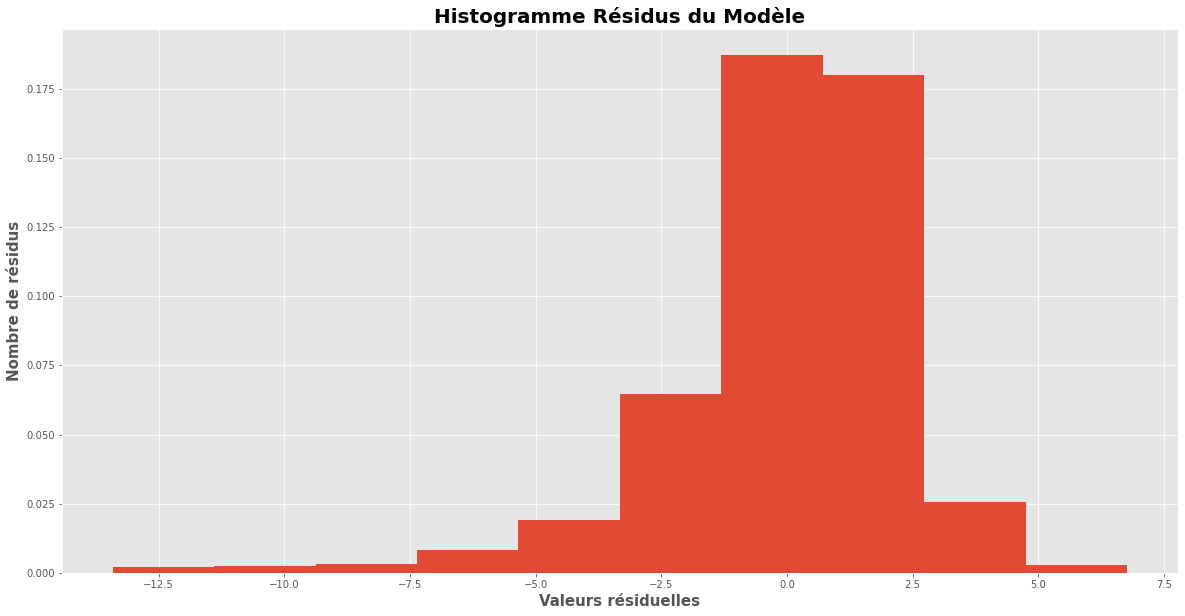

In [5]:
# Représentation graphique de la distribution de nos résidus
#Visualisation de la normalité des résidus : 
plt.figure(figsize=(20,10))

plt.hist(anova_income_4.resid, density=True)
plt.xlabel('Valeurs résiduelles', fontsize=15, fontweight='bold')
plt.ylabel('Nombre de résidus', fontsize=15, fontweight='bold')
plt.title('Histogramme Résidus du Modèle', fontsize=20, fontweight='bold')

plt.savefig('Graphs/residus_gboost.jpg')
plt.show()

La distribution de nos résidus semble suivre une loi normale avec une tendance à gauche.

### Droite de Henry

Le graphique qqplot permet de vérifier la compatibilité de la distributions. Dans notre cas, nous confrontons la distribution empirique des résidus avec la distribution théorique de la loi normale. On parle aussi de Droite de Henry. L’hypothèse nulle (normalité) est rejetée si la série de points s’écarte manifestement de la diagonale.

Text(0.5, 1.0, 'Q-Q Plot des résidus')

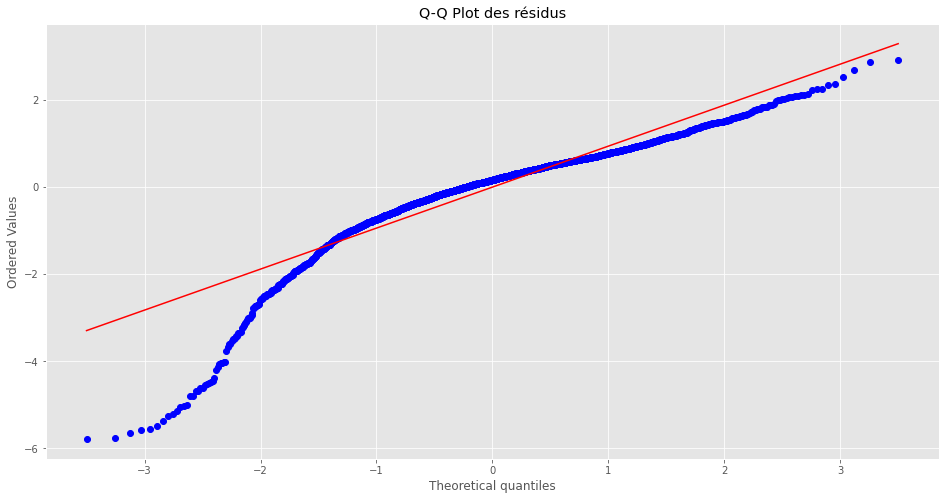

In [6]:
# Visualisation de la droite de Henry sur nos résidus
fig = plt.figure(figsize=(16,8))

# Calcul des résidus des valeur observé par rapport au variables prédite par notre régression linéaire
residus = anova_income_4.get_influence().resid_studentized_internal

stats.probplot(residus, plot = plt)
plt.title('Q-Q Plot des résidus')

La droite de Henry nous montre que nos variables semble suivre une loi normale.

### Utilisons maintenant le test de shapiro-Wilk car nous avons un échantillon plutôt restreint de <5000 individus.

In [7]:
#Importation des modules nécessaire aux test statistiques
from scipy.stats import ks_2samp, shapiro, bartlett, ttest_ind

### Test d'adéquation de Kolmogorov-Smirnov :

- H0 : Ma variable suit une loi normale
- H1 : Ma variable ne suit pas une loi normale

In [8]:
# Création des variables stockés les informations nécessaires au test de régression multiple
X_income = anova_income_4.resid
X_bar = X_income.mean()
X_sprime = X_income.std()

# Test de Kolmogorov-Smirnov car notre échantillon est plutôt volumineux (1.124.113 d'individus)
ks_2samp(anova_income_4.resid, list(np.random.normal(X_bar, X_sprime, 3000)))

KstestResult(statistic=0.11266666666666666, pvalue=5.371833875610945e-17)

Notre pvalue est inférieur à 0.05%, ce qui nous fait rejeter notre hypothèse H0.

Certes nos données ne suivent pas une loi normale parfaite, néanmoins comme vu sur les précédent graphiques nos données ne sont pas absurdes et peuvent-être utilisé.

### Test de Colinéarité

Vérification d'une évantuelle colinéarité de nos variables, savoir si 2 variables explicatives expliques-t-elle la même variance ou non.

In [9]:
# Importation de la librairie
from statsmodels.stats.outliers_influence import variance_inflation_factor 

In [10]:
# Vérification d'une possible colinéarité de nos variables sur le modèle non logaritmé
variables = anova_income_4.model.exog
[variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])]

[1.2238997043056683, 1.2168810469073292, 1.019929728742635, 1.0486943844972354]

Notre test de colinéarité est négatif. Nos coefficients sont en dessous de 10, même de 5.

### Test d'Homoscédasticité

Ce test va nous permettre de savoir si nos variables explicatives ont un effet significatif sur la variable à expliquer. Dans ce cas, la variance de l'erreur est constante pour toutes les estimations.

In [11]:
__, pval, __, f_pval = sms.het_breuschpagan(anova_income_4.resid, anova_income_4.model.exog)
print('p value test Breusch-Pagan:', pval)

p value test Breusch-Pagan: 4.097545384765223e-34


H0 = Homoscédasticité
H1 = Hétéroscédasticité

pvalue < 0.05 alors nous rejettons l'hypothèse H0, il y a hétéroscédasticité des résidus, c-à-d que la variance des résidus dans nos variables sont différentes et non constante.

### Points atypiques et influents

Les points influents correspondent aux observations qui pèsent significativement, voire exagérément, sur les calculs. Ils déterminent, dans une proportion à évaluer, les résultats de la régression. Il convient de les considérer avec précaution au moins pour interpréter correctement les coefficients obtenus. Dans certains cas, on peut considérer qu’une observation pèse trop sur la régression au point d’altérer les paramètres estimés.

Les tests se feront à hauteur d'alpha = 5%

n étant le nombres d'individus dans mon échantillon et p le nombre de variable dans ma régression.

In [12]:
# Stockage de nos paramètre
alpha = 0.05
n = len(train)
p = 4

# Création d'une copie de notre dataframe
train_copy = train.copy()

### Analyse des leviers avec seuil

Le seuil des leviers est de 2 * p/n
Il est importants de savoir quelles observations peuvent fausser le résultats de la régression.

In [13]:
# Stockage du paramètre du seuil
seuil = 2*p/n

In [14]:
# Création d'une variable qui va stocker le résultat d'évantuelle individus qui pourrait fausser notre régression
train_copy['levier'] = anova_income_4.get_influence().hat_matrix_diag

In [15]:
# Reduction de nos individus par pays pour un calcul plus rapide et une visualisation plus rapide
train_copy_levier = train_copy.groupby('id')['levier'].mean().reset_index()
train_copy_levier.head()

,id,levier
0,1,0.000986
1,2,0.000537
2,3,0.003717
3,4,0.001077
4,5,0.002121


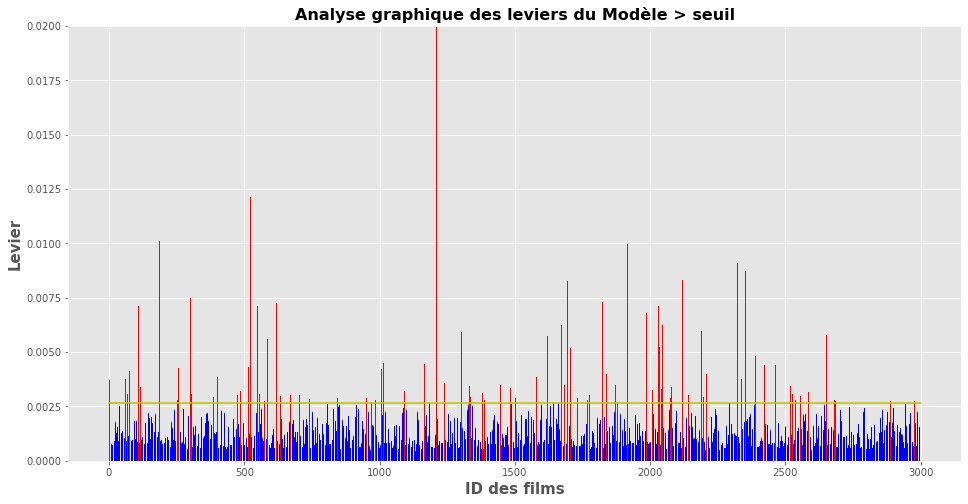

In [16]:
#Visualisation des leviers du Modèle non logarithmé par pays avec représentation du seuil
plt.figure(figsize=(16,8))


plt.bar(train_copy_levier.loc[train_copy_levier['levier'] <= seuil]['id'].index,
        train_copy_levier.loc[train_copy_levier['levier'] <= seuil]['levier'], color='b')
plt.bar(train_copy_levier.loc[train_copy_levier['levier'] > seuil]['id'].index,
        train_copy_levier.loc[train_copy_levier['levier'] > seuil]['levier'], color='r')
plt.plot([0, 3000], [seuil, seuil], color='y')

plt.ylim(top=0.02)
plt.xlabel('ID des films', fontsize=15, fontweight='bold')
plt.ylabel('Levier', fontsize=15, fontweight='bold')
plt.title('Analyse graphique des leviers du Modèle > seuil', fontsize=16, fontweight='bold')


plt.savefig('Graphs/levier_model1.jpg')
plt.show()

In [17]:
print("Les films qui ont un seuil trop élevé dans notre modèle : {}".format(len(train_copy_levier[train_copy_levier['levier'] > seuil]['id'])))
#Pourcentage de film hors seuil levier
print("Modèle : " + str(round(len(train_copy_levier[train_copy_levier['levier'] 
                    > seuil])/len(train_copy_levier['levier'])*100, 2)) + '%')
display(train_copy_levier[train_copy_levier['levier'] > seuil]['id'])

Les films qui ont un seuil trop élevé dans notre modèle : 374
Modèle : 12.47%


2          3
5          6
38        39
47        48
51        52
        ... 
2947    2948
2967    2968
2978    2979
2980    2981
2992    2993
Name: id, Length: 374, dtype: int64

### Analyse des résidus studentisé

Le seuil pour les résidus studentisés est une loi de Student à n-p-1 degrés de liberté.

Il est nécessaire d'observer le rôle conjoint du levier et du résidu standardisé.

In [18]:
# Création de nouvelles variables qui va stocké le calcul des résidus studentisé
train_copy_levier['rstudent'] = anova_income_4.get_influence().resid_studentized_internal

seuil_rstudent = st.t.ppf(1-alpha/2,n-p-1) # n-p-1 est le degré de liberté(ddl)

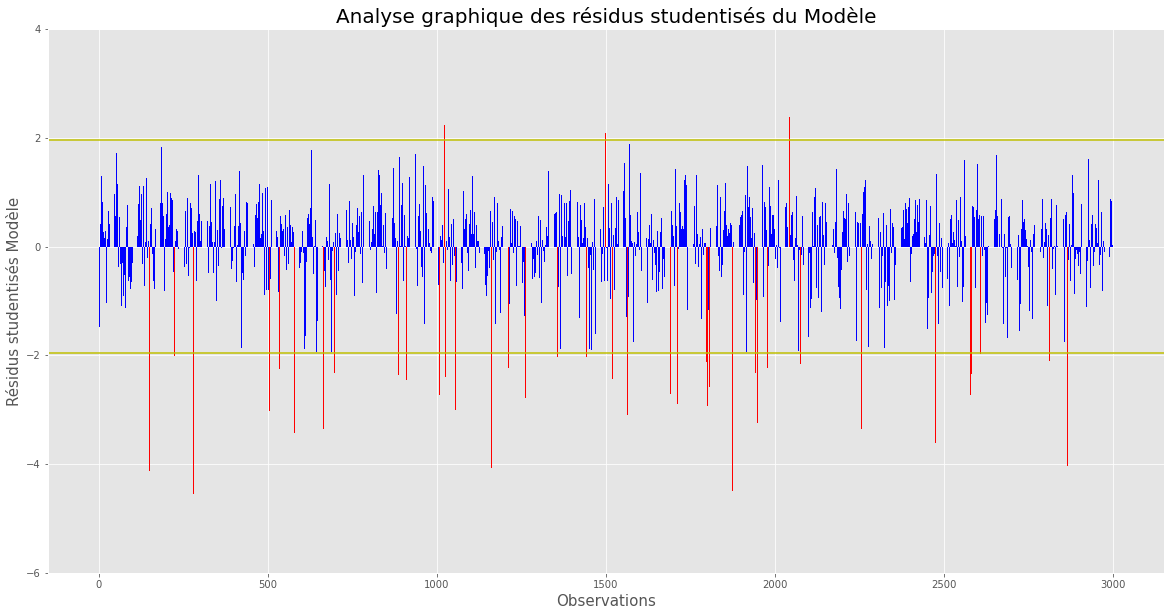

In [19]:
#Visualisation globale des résidus studentisés du Modèle non logarithmé avec représentation du seuil
plt.figure(figsize=(20,10))


plt.bar(train_copy_levier[(train_copy_levier['rstudent'] <= seuil_rstudent) & 
                             (train_copy_levier['rstudent'] >= -seuil_rstudent)]['id'].index,
        train_copy_levier[(train_copy_levier['rstudent'] <= seuil_rstudent) &
                             (train_copy_levier['rstudent'] >= -seuil_rstudent)]['rstudent'], color='b')

plt.bar(train_copy_levier[train_copy_levier['rstudent'] > seuil_rstudent]['id'].index, 
        train_copy_levier[train_copy_levier['rstudent'] > seuil_rstudent]['rstudent'], color='r')
plt.bar(train_copy_levier[train_copy_levier['rstudent'] < -seuil_rstudent]['id'].index, 
        train_copy_levier[train_copy_levier['rstudent'] < -seuil_rstudent]['rstudent'], color='r')


# Mise en place du seuil studentisé(1.9599), pour délimiter les valeurs qui sort de ce seuil
plt.axhline(y=seuil_rstudent, color='y', linestyle='-')
plt.axhline(y=-seuil_rstudent, color='y', linestyle='-')

plt.xlabel('Observations', fontsize=15)
plt.ylabel('Résidus studentisés Modèle', fontsize=15)
plt.title('Analyse graphique des résidus studentisés du Modèle', fontsize=20)

plt.ylim(-6, 4)
plt.savefig('Graphs/residus_studentises_modele.png')
plt.show()

In [20]:
# Comparaisons du nombre de valeurs sortant du seuil/influentes entre les deux modèles
print(str(len(train_copy_levier[(train_copy_levier['rstudent'] > seuil_rstudent) |
                               (train_copy_levier['rstudent'] < -seuil_rstudent)])),
                                'Valeurs influentes dans le modèle')

151 Valeurs influentes dans le modèle


In [21]:
# Comparons le pourcentage de valeurs influentes dans nos modèles
print('Modèle : ' + str((round(151 / len(train_copy_levier) * 100, 2))) + '%')

Modèle : 5.03%


### Distance de Cook

Ce test va nous permettre de visualiser de potentielle valeurs aberrantes qui mériterons une étude.

In [22]:
# Récupération des valeurs influentes dans notre modèle de régresion
influence = anova_income_4.get_influence()

# Stockage du calcul de la distance de cook pour chaque observations
cooks = influence.cooks_distance[0]

# Création de nouvelles variables dans notre dataframe
train_copy_levier['cook'] = cooks

In [23]:
# Définir le seuil de la distance de cook qui est exprimé comme :
seuil_dcook = 4/(n-p)

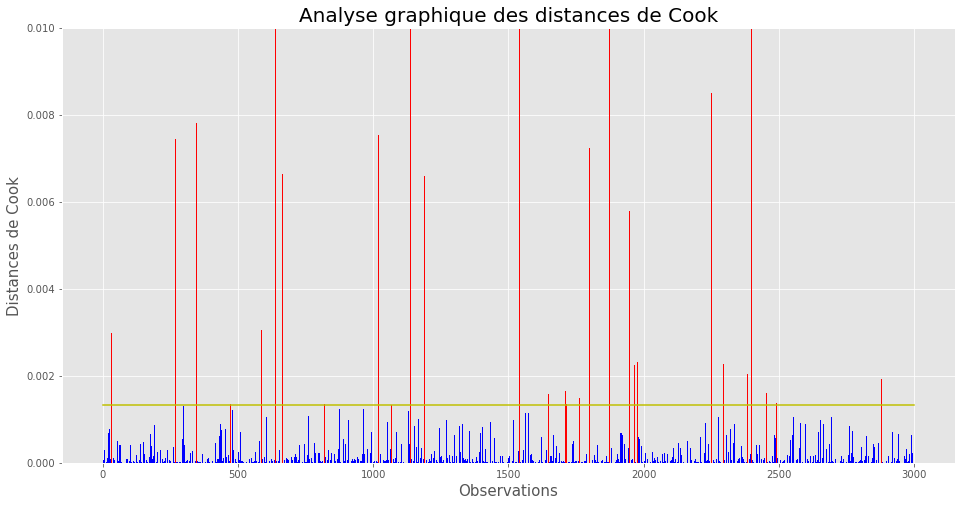

In [24]:
#Visualisation globale des distances de Cook du Modèle non logarithmé avec représentation du seuil
plt.figure(figsize=(16,8))

plt.bar(train_copy_levier.loc[train_copy_levier['cook'] < seuil_dcook]['id'].index,
        train_copy_levier.loc[train_copy_levier['cook'] < seuil_dcook]['cook'], color='b')
plt.bar(train_copy_levier.loc[train_copy_levier['cook'] >= seuil_dcook]['id'].index,
        train_copy_levier.loc[train_copy_levier['cook'] >= seuil_dcook]['cook'], color='r')

plt.plot([0, 3000], [seuil_dcook, seuil_dcook], color='y')
plt.ylim(0, 0.010)

plt.xlabel('Observations', fontsize=15)
plt.ylabel('Distances de Cook', fontsize=15)
plt.title('Analyse graphique des distances de Cook', fontsize=20)

plt.savefig('Graphs/dcook_model.png')
plt.show()

In [25]:
# Comparaisons du nombre de valeurs sortant du seuil/influentes entre les deux modèles
print(str(len(train_copy_levier[(train_copy_levier['cook'] > seuil_dcook)])),
                                'Valeurs influentes dans le modèle')

161 Valeurs influentes dans le modèle


In [26]:
# Comparons le pourcentage de valeurs influentes dans nos modèles
print('Modèle : ' + str((round(161 / len(train_copy_levier) * 100, 2))) + '%')

Modèle : 5.37%
